In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import keras
import tensorflow.keras.backend as K
import model_function

Define input images of digits

In [127]:
number_array = np.zeros((10, 5, 5), dtype=float)

# 0
number_array[0, 0, :] = 1  
number_array[0, :, 0] = 1 
number_array[0, :, 4] = 1  
number_array[0, 4, :] = 1  

# 1
number_array[1, :, 2] = 1 
number_array[1, 1, 1] = 1 
number_array[1, 4, 1:4] = 1  

# 2
number_array[2, 0, 1:-1] = 1  
number_array[2, 1, -1] = 1 
number_array[2, 1, 0] = 1  
number_array[2, 2, -2] = 1  
number_array[2, 3, 1:-2] = 1
number_array[2, 4, :] = 1  

# 3
number_array[3, 0, :] = 1  
number_array[3, 2, :] = 1  
number_array[3, 4, :] = 1  
number_array[3, :, -1] = 1  
number_array[3, 1, -1] = 1  

# 4
number_array[4, :, 4] = 1  
number_array[4, 0:3, 0] = 1  
number_array[4, 2, :] = 1  

# 5
number_array[5, 0, :] = 1  
number_array[5, 1, 0] = 1  
number_array[5, 2, :] = 1  
number_array[5, 3, -1] = 1  
number_array[5, 4, :] = 1  

# 6
number_array[6, 0, :] = 1  
number_array[6, 1, 0] = 1  
number_array[6, 2, :] = 1  
number_array[6, 3, -1] = 1  
number_array[6, 3, 0] = 1  
number_array[6, 4, :] = 1  

# 7
number_array[7, 0, :] = 1  
number_array[7, :, -1] = 1  

# 8
number_array[8, 0, :] = 1   
number_array[8, :, 0] = 1  
number_array[8, :, 4] = 1 
number_array[8, 2, :] = 1  
number_array[8, 4, :] = 1 
 

# 9
number_array[9, 0, :] = 1  
number_array[9, 4, :] = 1  
number_array[9, :, -1] = 1  
number_array[9, 2, :] = 1  
number_array[9, 1, 0] = 1 

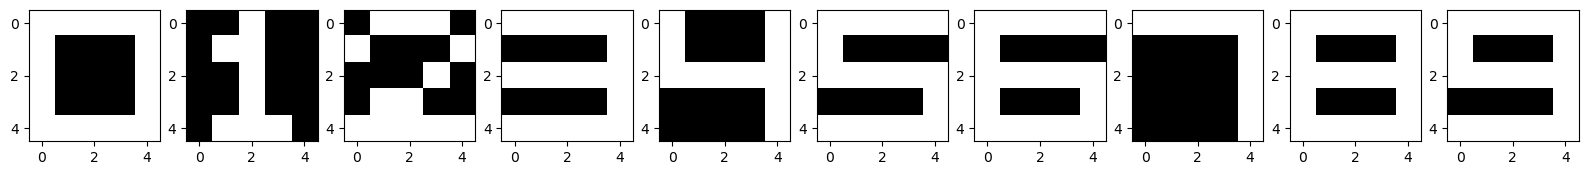

In [128]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
for i,array in enumerate(number_array):
    axs[i].imshow(array, cmap='gray')

Set Parameters

In [129]:
#times in ms
base_on_time= 50
on_time = 50
off_time= 20
#current in mA
baseline_current = 1.0
model_input_array = np.zeros((1,3), dtype=float)

Load ML model

In [130]:
load = True
model_path ='models/2024-04-17_12-35-13_single_step_41/model.h5'

if load:
    model = keras.models.load_model(model_path)

For each row in image, generate pulse sequence

In [131]:
def number_to_pulse_train_generator(input:np.ndarray, base_on_time:int, on_time:int, off_time:int, modulation:float)->np.ndarray:
    '''Pulse train output is a sequence of D*2 integers alternating between on pulse duration and off pulse duration'''
    
    output_current = np.zeros_like(input)
    output_signal= np.zeros((input.shape[0],input.shape[0]*2))
    for irow, row in enumerate(input):
        for icol, value in enumerate(row):
            if icol ==0:
                on = base_on_time+on_time*(value*modulation)
                off = off_time+on_time*((1-value)*modulation)
                model_input_array[0,:] = np.array([baseline_current, on, off])
                output_signal[irow,2*icol]= on
                output_signal[irow,2*icol+1]= off
                output_current[irow,icol]= model.predict(model_input_array, verbose=0)              
            else:    
                on = base_on_time+on_time*(value*modulation)
                off = off_time+on_time*((1-value)*modulation)            
                model_input_array[0,:] = np.array([output_current[irow,icol-1], on, off]) 
                output_signal[irow,2*icol]= on
                output_signal[irow,2*icol+1]= off
                output_current[irow,icol]= model.predict(model_input_array, verbose=0)
                
    return output_current, output_signal

In [132]:
def pixel_to_signal_array(input:np.ndarray, base_on_time:int, on_time:int, off_time:int, modulation:float, max_int):
    '''Pulse train output is a sequence of D*2 integers alternating between on pulse duration and off pulse duration'''
    
    #normalize input to range [0,1]
    input = input.T/max_int
    #create output arrays of proper size
    output_current = np.zeros_like(input)
    output_signal= np.zeros((input.shape[0],input.shape[1]*2))
    #create auxiliary arrays to hold on/off times
    on_array =  np.zeros_like(input)
    off_array = np.zeros_like(input)
    

    #create NN input array
    # model_input_array = np.zeros((input.shape[0],input.shape[1],  3))
    
    #create auxiliary array with baseline current
    baseline_current_array = np.empty_like(input)
    baseline_current_array.fill(baseline_current)
    # model_input_array[0, 0, 1] = baseline_current_array, on_array[0], off_array[0]
    # model_input_array[:, 0, 0] = baseline_current_array[:,0]
    # model_input_array[:, 0, 1] = on_array[:,0]
    # model_input_array[:, 0, 2] = off_array[:,0]
    # print(model_input_array.shape)
    # set first on off time based on first column input
    for i, input_row in enumerate(input):
        on_array[i] = base_on_time+on_time*(input_row*modulation)
        off_array[i] = off_time+on_time*((1-input_row)*modulation)
        
        if i ==0: 
            model_input= np.stack([baseline_current_array[0,:], on_array[i], off_array[i]], axis=1)
            # print(i, model_input)
            # print(model.predict(model_input, verbose=0).flatten()) 
            # print(output_current[i,:]  )
            output_current[i,:] = model.predict(model_input, verbose=0).flatten()
            # print(output_current[i,:])
        else:
            model_input= np.stack([output_current[i-1], on_array[i], off_array[i]], axis=1)
            output_current[i,:] = model.predict(model_input, verbose=0).flatten()
        print(f'{i}/{input.shape[0]}', end='\r')      
             

    # Transpose back           
    return output_current.T, on_array.T, off_array.T

In [133]:
def draw_pulse_train_outcome(source_image,current,pulse_train):
    fig, axs = plt.subplots(pulse_train.shape[0],sharex= True, figsize=(3,3))
    for irow, row in enumerate(pulse_train):
        y_values = []
        for i,value in enumerate(row):
            if i%2==0:
                y_values.extend([1]*int(value))
            else:
                y_values.extend([0]*int(value))
        axs[irow].fill_between(range(len(y_values)),y_values, linestyle='-', label=irow)  
        # plt.legend()
    fig.supxlabel('Time (ms)')
    fig.supylabel('Signal')
    fig.suptitle('Device input signal per row')



    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
    axs[0].imshow(source_image, cmap='gray')
    axs[1].imshow(current, cmap='inferno')
    axs[0].set_xlabel('Column count')
    axs[1].set_xlabel('Pulse count')
    axs[0].set_ylabel('Row count')
    axs[1].set_ylabel('Row count')
    axs[0].set_title('Source image')
    axs[1].set_title('Current heatmap')
    plt.xlabel('Pulse count')
    plt.ylabel('Row count')

    plt.figure(figsize=(3, 3))
    for i, row in enumerate(current):
        plt.plot(range(len(row)),row, marker='o', linestyle='-', label=i)  
    # plt.legend()
    plt.xlabel('Pulse count')
    plt.ylabel('Current (mA)')
    plt.title('Device output per row signal')

    
        

In [134]:
def draw_pulse_train_array(source_array,current,on_times,off_times):
    pulse_train = np.zeros((current.shape[0],off_times.shape[1]*2))
    # pulse_train = pulse_train.T
    pulse_train[:, ::2] = on_times
    pulse_train[:, 1::2] = off_times
    # pulse_train = pulse_train.T
    fig, axs = plt.subplots(pulse_train.shape[0],sharex= True, figsize=(3,3))
    for irow, row in enumerate(pulse_train):
        y_values = []
        for i,value in enumerate(row):
            if i%2==0:
                y_values.extend([1]*int(value))
            else:
                y_values.extend([0]*int(value))
        axs[irow].fill_between(range(len(y_values)),y_values, linestyle='-', label=irow)  
        # plt.legend()
    fig.supxlabel('Time (ms)')
    fig.supylabel('Signal')
    fig.suptitle('Device input signal per row')



    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
    axs[0].imshow(source_array, cmap='gray')
    axs[1].imshow(current, cmap='inferno')
    axs[0].set_xlabel('Column count')
    axs[1].set_xlabel('Pulse count')
    axs[0].set_ylabel('Row count')
    axs[1].set_ylabel('Row count')
    axs[0].set_title('Source image')
    axs[1].set_title('Current heatmap')
    plt.xlabel('Pulse count')
    plt.ylabel('Row count')

    plt.figure(figsize=(3, 3))
    for i, row in enumerate(current):
        plt.plot(range(len(row)),row, marker='o', linestyle='-', label=i)  
    # plt.legend()
    plt.xlabel('Pulse count')
    plt.ylabel('Current (mA)')
    plt.title('Device output per row signal')

    

In [135]:
# number_array.reshape(-1, number_array.shape[-1])

In [139]:
# current_two,pulse_train_two = number_to_pulse_train_generator(number_array[2], base_on_time,on_time, off_time, modulation=1)
current_two,on_array_two, off_array_two = number_to_pulse_train_generator_array(number_array[2], base_on_time,on_time, off_time, modulation=1, max_int=1)


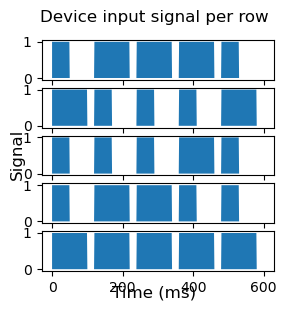

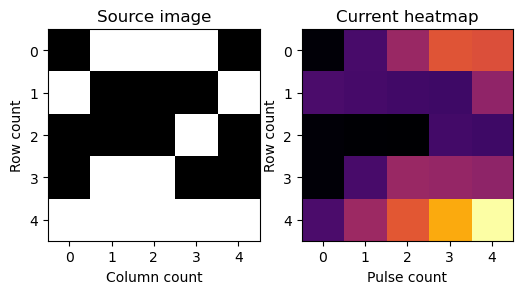

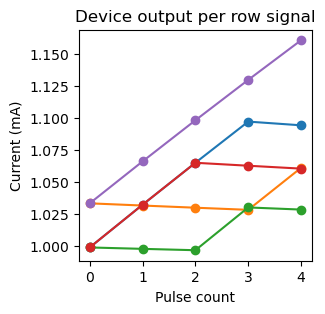

In [141]:
draw_pulse_train_array(number_array[2],current_two,on_array_two, off_array_two)

In [142]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)



In [11]:
#try on MNIST dataset
x_train_current,x_train_on, x_train_off = number_to_pulse_train_generator(x_train.reshape(-1, number_array.shape[-1]), base_on_time, on_time, off_time, modulation=1)


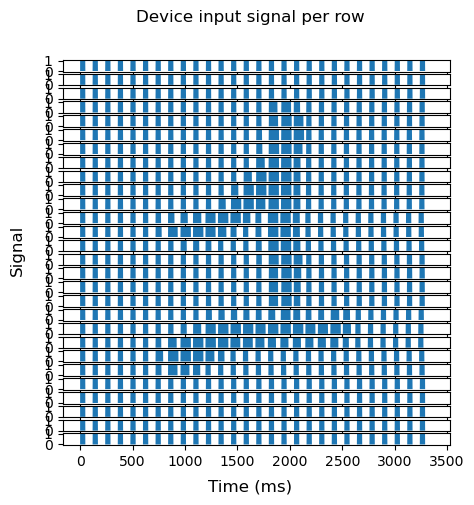

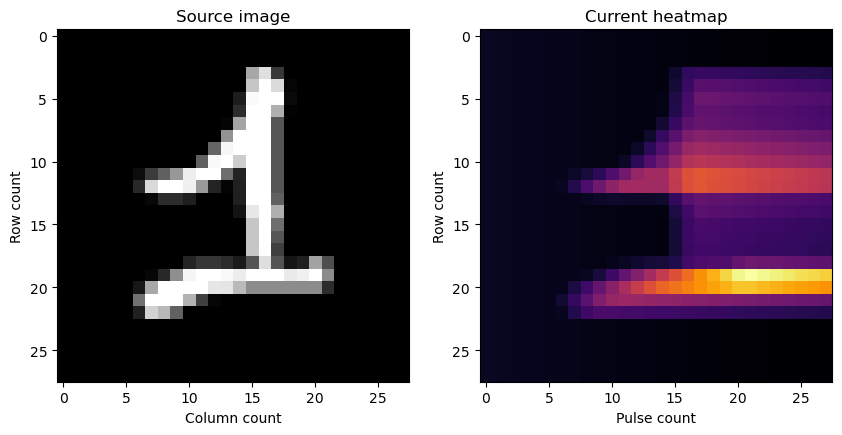

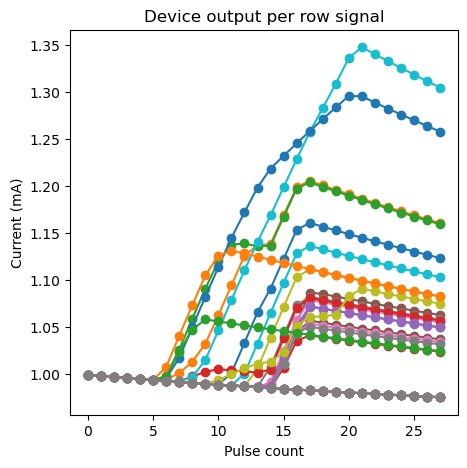

In [12]:
draw_pulse_train_outcome(source_image_1,current_1,pulse_train_1)

In [23]:
source_image_2 = x_train[26345,::4,::4]/255
current_2,pulse_train_2 = number_to_pulse_train_generator(source_image_2, base_on_time, on_time, off_time, modulation=1)

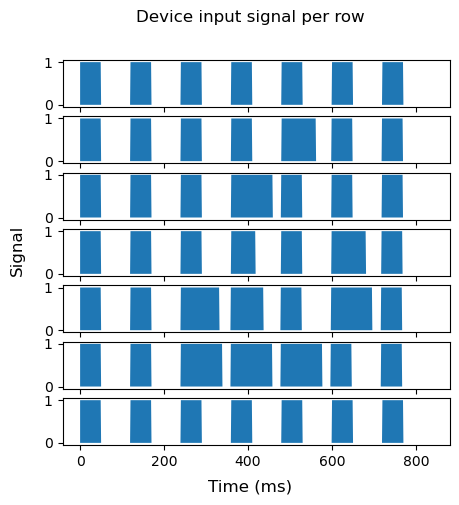

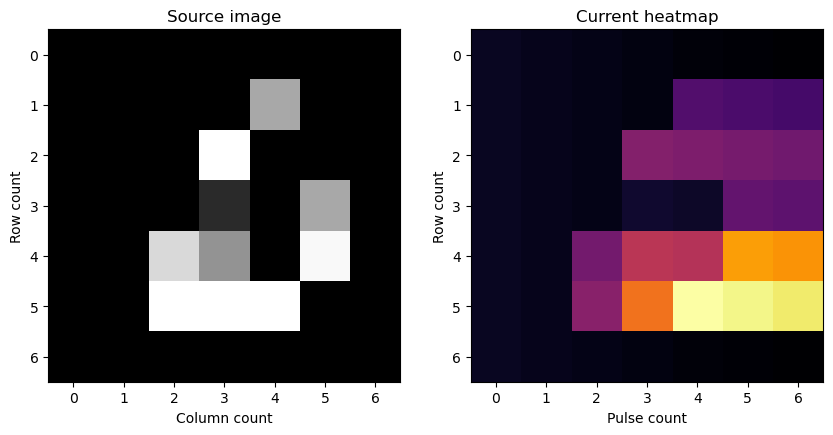

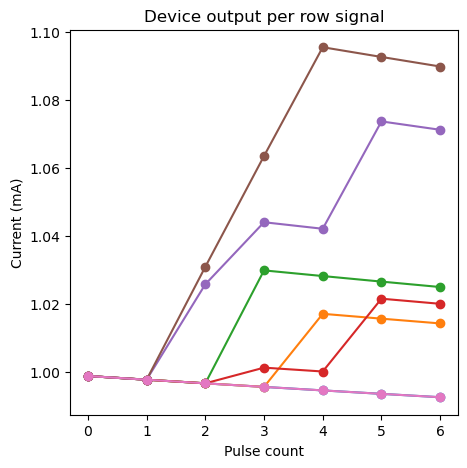

In [24]:
draw_pulse_train_outcome(source_image_2,current_2,pulse_train_2)

In [16]:
#downsample database
# input_size = 28
# output_size = 7
# bin_size = input_size // output_size
# x_train_small = x_train.reshape((x_train.shape[0],output_size, bin_size,
#                                       output_size, bin_size)).max(4).max(2)

In [79]:
x_train_small = number_array

In [80]:
#times in ms
base_on_time= 50
on_time = 50
off_time= 20
#current in mA
baseline_current = 1.0
model_input_array = np.zeros((1,3), dtype=float)




x_train_current = np.zeros((x_train.shape[0],x_train.shape[1],x_train.shape[1]))
x_train_pulsetrain = np.zeros((x_train.shape[0],x_train.shape[1],x_train.shape[1]*2))

x_test_current = np.zeros((x_test.shape[0],x_test.shape[1],x_test.shape[1]))
x_test_pulsetrain = np.zeros((x_test.shape[0],x_test.shape[1],x_test.shape[1]*2))

x_train_small_current = np.zeros((x_train_small.shape[0],x_train_small.shape[1],x_train_small.shape[1]))
x_train_small_pulsetrain = np.zeros((x_train_small.shape[0],x_train_small.shape[1],x_train_small.shape[1]*2))



In [81]:


for i, array in enumerate(number_array):
  x_train_small_current[i,:,:], x_train_small_pulsetrain[i,:,:]  = number_to_pulse_train_generator(array, base_on_time, on_time, off_time, modulation=1)

with open('outputs/x_train_current.npy', 'wb') as f:
    np.save(f, x_train_small_current)
with open('outputs/x_train_pulstrain.npy', 'wb') as f:
    np.save(f, x_train_small_pulsetrain)


# for i, array in enumerate(x_test[:10]):
#   x_test_current[i,:,:], x_test_pulsetrain[i,:,:]  = number_to_pulse_train_generator(array/255, base_on_time, on_time, off_time, modulation=1)
 
# with open('outputs/x_test_current.npy', 'wb') as f:
#     np.save(f, x_test_current)
# with open('outputs/x_test_pulstrain.npy', 'wb') as f:
#     np.save(f, x_test_pulsetrain) 